# Time series forecasting with sktime
Estimated time: 40 min

## Introduction

What is a time series and what can we forecast?

![](../images/ts_quiz.png)

Factors that influence ”forecastability”:
1. How much data is available.
2. How similar the future is to the past.
3. How well we understand the factors that contribute to it.
4. Whether the forecasts can affect the thing we are trying to forecast.

## Agenda
- Univariate forecasting
- Univariate with exogenous
- Multivariate
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

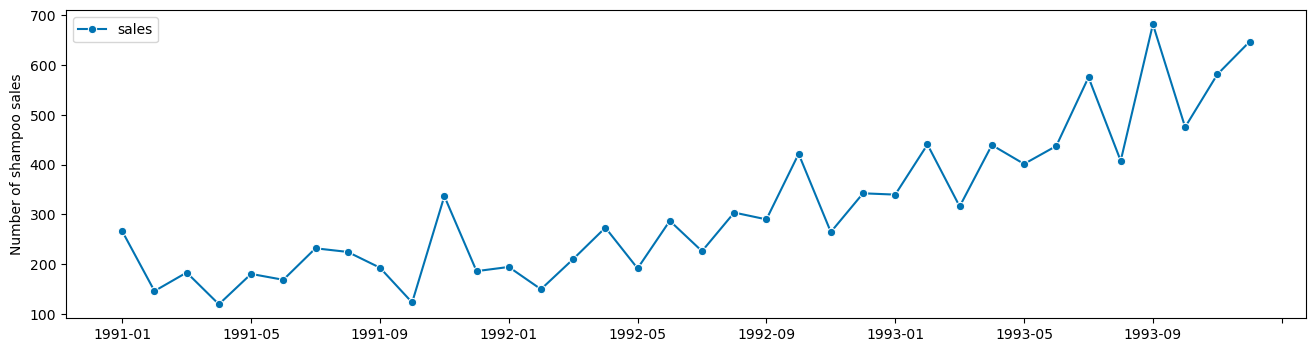

In [1]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()
plot_series(y, labels=["sales"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

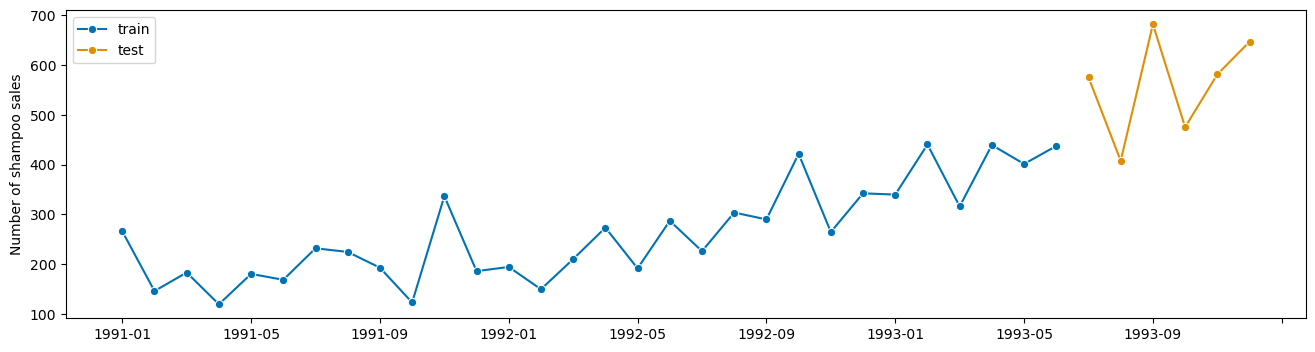

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
plot_series(y_train, y_test, labels=["train", "test"])

10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

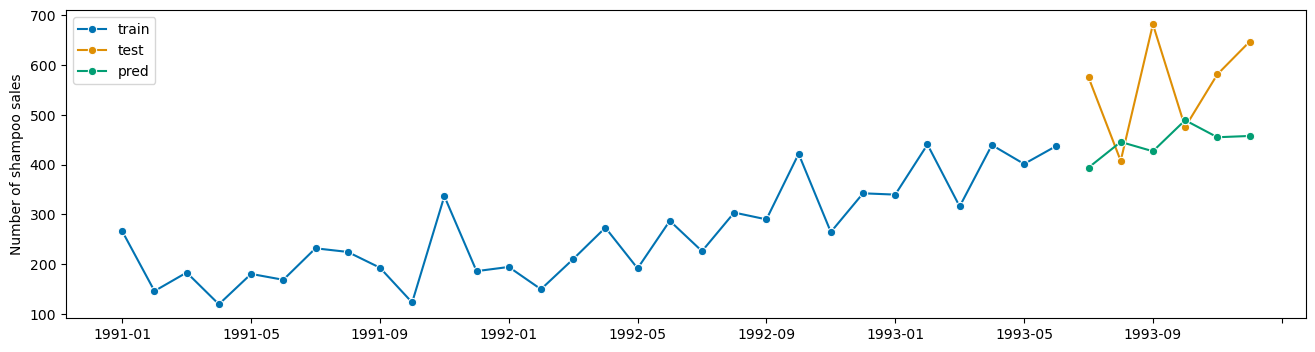

In [9]:
from sktime.forecasting.fbprophet import Prophet

# 1) Define the model
forecaster = Prophet()

# 2) Fit on train data
forecaster.fit(y_train) 

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6]
y_pred = forecaster.predict(fh)  

plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

In [11]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"Prophet - sMAPE error: {smape(y_test, y_pred):.1%}")

Prophet - sMAPE error: 25.7%


## Univariate forecasting

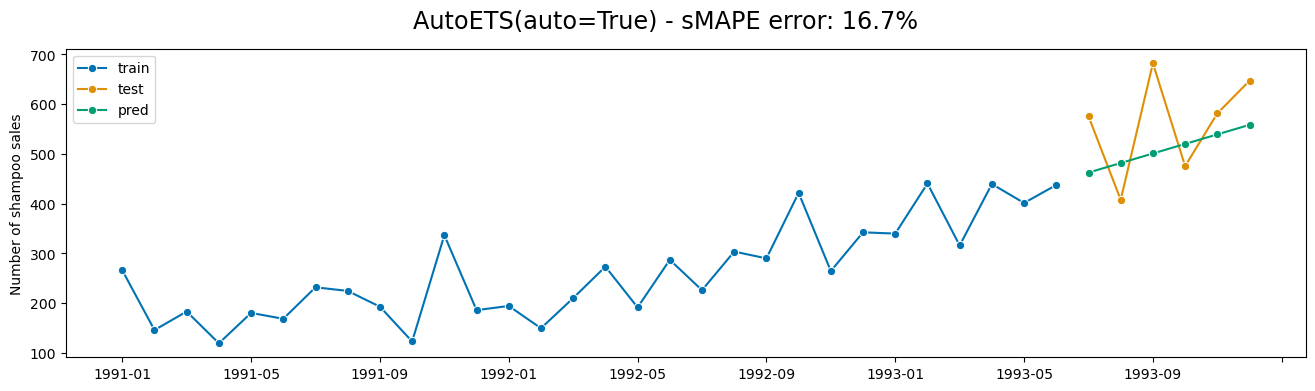

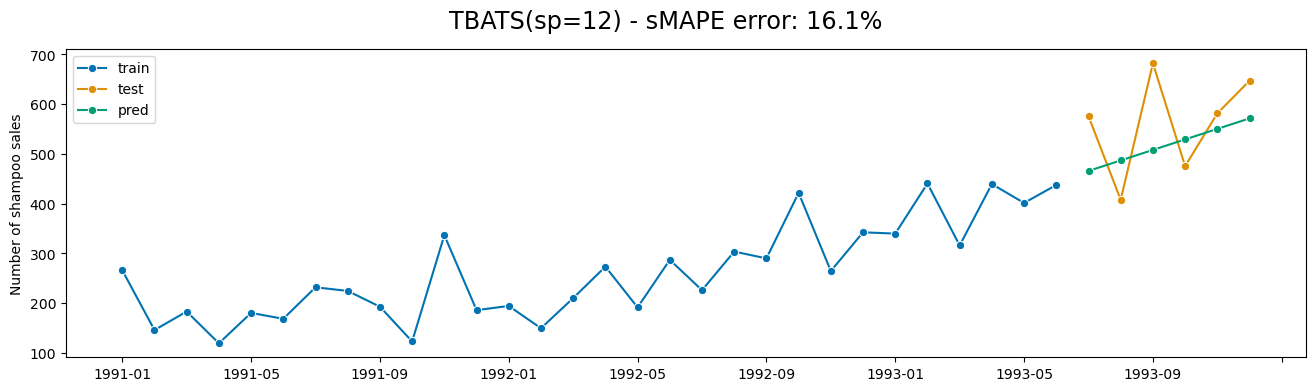

In [7]:
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS

forecasters = [AutoETS(auto=True), TBATS(sp=12)]

for forecaster in forecasters:
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    title = f"{str(forecaster)} - sMAPE error: {smape(y_test, y_pred):.1%}"
    plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title)

## Univariate with exogenous

## Multivariate

## Probabilistic forecasting

## Hierarchical forecasting